# Scraping

In [10]:
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

## 1. Selenium
## 1.1 Scrape links

In [48]:
url = "https://ec.europa.eu/commission/presscorner/home/en?dotyp=&keywords=GHG&commissioner="
driver = webdriver.Chrome()
driver.get(url)

In [52]:
page_content = driver.find_element(By.ID, 'news-block')
# Now, find all <a> tags *within* that specific 'page_content' element
all_links= page_content.find_elements(By.TAG_NAME, 'a')

links = []
for link in all_links:
    href = link.get_attribute('href')
    text = link.text
    #print(f"Link Text: '{text}', URL: '{href}'")
    links.append(href)
links = [link for link in links if link!=None and len(link)>0]
links[:2]

['https://ec.europa.eu/commission/presscorner/detail/en/mex_25_1333',
 'https://ec.europa.eu/commission/presscorner/detail/en/mex_25_1287']

## 1.2 Scrape all links

In [87]:
#driver = webdriver.Chrome()
def scrape_page(url):
    driver.get(url)
    time.sleep(4)
    #page_title
    page_title = driver.find_element(By.TAG_NAME, 'h1').text
    #page_content
    page_content = driver.find_element(By.CLASS_NAME, 'ecl-col-l-9').text
    #date
    els = driver.find_elements(By.CLASS_NAME, 'ecl-page-header__meta-item')
    els = [el.text for el in els]
    date = next((item for item in els if re.search(r'\d{4}', item)), None)
    
    final_text = f"{page_title}\n{page_content}"
    return date.replace(",","").replace(" ", "_"), final_text

### 1.2.1 Example

In [63]:
date, final_text = scrape_page(links[1])
final_text[:400]

"Daily News 20 / 05 / 2025\nCommission welcomes political agreement on the progressive rollout of Europe's New Digital Border System\nThe European Commission welcomes yesterday's provisional political agreement by the European Parliament and the Council on the Commission's proposal for a progressive rollout of Europe's new digital border system, the Entry/Exit System (EES).\nThis agreement will allow "

### 1.2.2 Scrape all

In [65]:
scrape_dictionary = {}
from tqdm import tqdm
for link in tqdm(links):
    try:
        date, final_text = scrape_page(link)
        scrape_dictionary[date] = final_text
    except:
        print("LINK DIDNT WORK", link)


### 1.2.3 Convert results to data frame

In [82]:
import pandas as pd
df_text = pd.DataFrame.from_dict(scrape_dictionary, orient = 'index', columns = ['text'])
df_text.index.name = 'date'
df_text.tail(2)

,text
date,
Apr_12_2024,Questions and Answers on the revised Energy Pe...
Apr_5_2024,Commission approves €350 million German State ...


### 1.2.4 Export

In [83]:
import os
export_path = "../../data/examples/module_4"
os.listdir(export_path)

[]

In [85]:
file_name = f"{export_path}/eu_press_releases_ghg.csv"
df_text.to_csv(file_name)

In [88]:
pd.read_csv(file_name).head(2)

,date,text
0,May_26_2025,Daily News 26 / 05 / 2025\nEU organises firefi...
1,May_20_2025,Commission approves €1.2 billion Dutch State a...


# 2. Basic NLP

## 2.A Download Manifesto Data
- https://manifesto-project.wzb.eu/information/documents/api

In [3]:
import dotenv
import os
import sys

sys.path.append("../../..")
from src.data.download_manifesto import DownloadManifesto

dotenv.load_dotenv()
dataset_key = "MPDS2024a"
version = '2024-1'
api_key = os.getenv("MANIFESTO_API")

In [5]:
# Usage example:
downloader =  DownloadManifesto(dataset_key, version, api_key)
result = downloader.get_country_data("United States")
result.head(2)

,countryname,party,partyname,date,keys
2562,United States,61320,Democratic Party,192011,61320_192011
2563,United States,61620,Republican Party,192011,61620_192011


In [6]:
df, metadata = downloader.get_metadata(result)
df.head(2)

,countryname,party,partyname,date,keys,manifesto_id
2562,United States,61320,Democratic Party,192011,61320_192011,NaN
2563,United States,61620,Republican Party,192011,61620_192011,NaN


In [7]:
df_final = downloader.get_texts(df)  # Get texts
df_final.head(2)

party         partyname          keys  manifesto_id  \
countryname   date                                                          
United States 196011  61320  Democratic Party  61320_196011  61320_196011   
              196011  61620  Republican Party  61620_196011  61620_196011   

                                                                   text  
countryname   date                                                       
United States 196011  In 1796, in America's first contested national...  
              196011  PREAMBLE The United States is living in an age...

In [8]:
df_final.to_parquet("../../../data/examples/module_4/manifesto_us.parquet")

### 2.A.1 META data

In [4]:
import requests
import pandas as pd

dataset_key = "MPDS2024a"
version = '2024-1'

def get_core_data(api_key, dataset_key):
    base_url = "https://manifesto-project.wzb.eu/api/v1/get_core"
    params = {"api_key": api_key, "key": dataset_key}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None
        
response = get_core_data(api_key, dataset_key)
headers = response[0]
data = response[1:]

df = pd.DataFrame(data, columns=headers)
df.head(2)

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
0,11,Sweden,0,0,17/09/1944,194409,11220,Communist Party of Sweden,SKP,20,...,NA,NA,NA,9.6,1.9,1.9,0,1.9,2024a,JN1LZH
1,11,Sweden,0,0,17/09/1944,194409,11320,Social Democratic Labour Party,SAP,30,...,NA,NA,NA,-37.8,3.3,2.2,33.4,5.6,2024a,CMR7F6


# 2.1 Word clouds

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class WordCount:
    def __init__(self, text_col, df):
        self.text_col = text_col
        self.df = df

    def word_cloud(self):
        text = ' '.join(self.df[self.text_col].astype(str))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    def create_word_df(self, **vectorizer_args):
        vectorizer = CountVectorizer(**vectorizer_args)
        self.dtm = vectorizer.fit_transform(self.df[self.text_col]).toarray()
        self.vocab = vectorizer.get_feature_names_out()
        return pd.DataFrame(self.dtm, columns=self.vocab, index = self.df.index)

        
textprocess = WordCount(text_col = 'text', df = df_final)
textprocess.create_word_df(
    strip_accents = 'unicode',  # Remove accents from characters. 'unicode' or 'ascii'.
    analyzer = 'word',          # Whether the feature should be made of word or character n-grams or a mixture of both.
    stop_words = 'english',     # Remove stop words. Can be a list of stop words or a string from {'english', 'spanish'}.
    lowercase = True,           # Convert text to lowercase.
    max_df=1.0,                 # When building the vocabulary, ignore terms that have a document frequency strictly larger than the given threshold.
    min_df=.8                    # When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold.
).head(2)

000  10  100  40  ability  able  abroad  abuse  accept  \
countryname   date                                                             
United States 196011    1   0    1   2        5     2      12      1       3   
              196011    2   0    0   0        2     4       4      0       1   

                      access  ...  worker  workers  working  works  world  \
countryname   date            ...                                           
United States 196011       7  ...       3       20        8      3     58   
              196011       0  ...       0        6        5      0     31   

                      worth  year  years  young  youth  
countryname   date                                      
United States 196011      1    15     23      9      4  
              196011      1     2     10      0      5  

[2 rows x 971 columns]

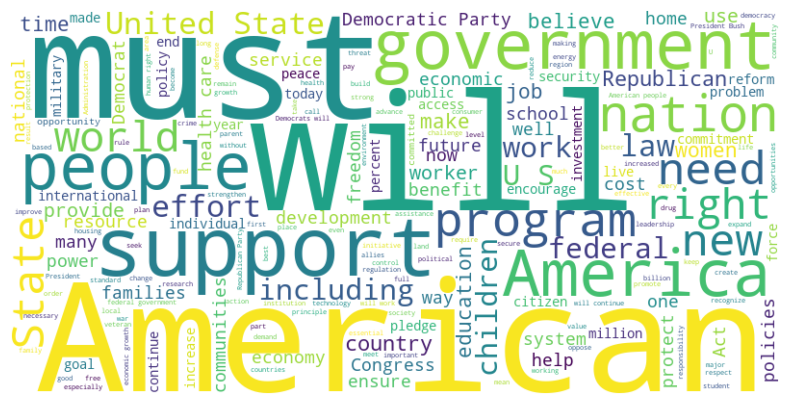

In [11]:
textprocess.word_cloud()